Disclaimer: Due to time constraints, we did most of the data analysis on the 2020 dataset, assuming that the various statistics would be consistent across the other years. But by the end of the notebook all the years of the dataset will have been cleaned and filtered as described below.

We start things off by mounting the drive on the Google Colab, doing necessary imports and defining some useful constants:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#There is a bug between the most recent version of pandas and Google Colab, so we use an older version
!pip install pandas==1.0.5

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import ast
import datetime
import hashlib
from IPython.display import clear_output
!pip install tldextract
import tldextract
from collections import defaultdict



pd.__version__

'1.0.5'

In [ ]:
path_to_folder = '/content/drive/MyDrive/Quotebank'
path_to_modified_folder = '/content/drive/MyDrive/Quotebank-modified'
filenames = ['quotes-2015.json.bz2','quotes-2016.json.bz2','quotes-2017.json.bz2','quotes-2018.json.bz2','quotes-2019.json.bz2','quotes-2020.json.bz2' ]
chunksize = 300000




Then, we define here functions that we will use for filtering the dataset in various ways, that we will go into next.

In [ ]:
#Filters the chunk so that only entries with exactly one Qid are returned
def filterSingleQid(chunk):
  return chunk[chunk['qids'].str.len().eq(1)]

#Filters the chunk so that only entries with confidence percentage of main speaker above 40%; Should be used on JSON-loaded files, as they automatically parse lists
def filterPercentageJSON(chunk):
  return chunk[chunk["probas"].apply(lambda x:float(x[0][1]) >= 0.4)]

#Filters the chunk so that only entries with confidence percentage of main speaker above 40%; Should be used on CSV-loaded files, as lists are loaded as string and need to be parsed
def filterPercentageCSV(chunk):
  return chunk[chunk["probas"].apply(lambda x:float(ast.literal_eval(x)[0][1]) >= 0.4)]

#Filters the chunk so that only entries with quotation between 10 and 500 characters are kept
def filterQuoteLength(chunk):
  return chunk[(chunk['quotation'].apply(lambda x:len(x)) > 10) & (chunk['quotation'].apply(lambda x:len(x)) < 500)]

#Filters the chunk so that only unique quoteID are kept; a list of precedent Ids can be provided to check uniqueness across chunks
def filterUniqueIds(chunk, precedentIds):
  chunk = chunk.drop_duplicates(subset=["quoteID"], keep="first")
  return chunk[chunk['hashIds'].apply(lambda x: x not in precedentIds)]

#Filters the chunk so that only entries with dates corresponding with dataset_date are kept
def filterIllegalDates(chunk,dataset_date):
  return chunk[chunk['date'].apply(lambda x: x.year == dataset_date)]


Here, we start working on the 2020 year as mentionned in the disclaimer.
The first thing we do is to filter out any quotes having more or less than one Qid associated with it, in order to associate it with the correct person later down the line. While it likely isn't the best method (amongst other things, it will filter out people that have multiple Qids associated with them, e.g. "Donald Trump" and "President Trump"), we couldn't come up with a reliable alternative that would be runnable on the entire dataset before the deadline.

Also of note is that we store the result in csv format: that is because most more optimized format don't support appending to one file as we process chunks, and we ran into trouble with the one that do (HDF5), so we decided to stick with a simpler format.

In [ ]:

usableCount = 0
totalCount = 0
filename = filenames[-1]

df = pd.read_json(os.path.join(path_to_folder, filename), lines=True, compression='bz2', chunksize=chunksize)

modified_filename = "single-qids-" + filename
chunkCount = 1
header = True
#Removes file if it exists, as the 'append' mode will otherwise keep growing it
try:
    os.remove(os.path.join(path_to_modified_folder, modified_filename))
except OSError:
    pass
#Iterates through the chunks
for chunk in df:
  #This prints the chunk number, to know where the program currently is in the output
  clear_output(wait=True)
  print(chunkCount)

  totalCount  = totalCount + chunk.shape[0]
  
  chunk = filterSingleQid(chunk)

  usableCount = usableCount + chunk.shape[0]

  chunk.to_csv(os.path.join(path_to_modified_folder, modified_filename),
        header=header, mode='a', index = False)
  
  header = False
  chunkCount+=1

print("Total count: " + str(totalCount))
print("usable: " + str(usableCount))

18
Total count: 5244449
usable: 2511905


As we can see, we lose roughly half of the dataset with this method; considering the size of it, we think it will still be more than enough to produce interesting results.

In [ ]:
#Sanity check that the CSV files are correct
df = pd.read_csv(os.path.join(path_to_modified_folder, "single-qids-quotes-2020.json.bz2"), compression='bz2', chunksize=chunksize)
chunk = next(df)
chunk.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,['Q367796'],2020-01-16 12:00:13,1,"[['Sue Myrick', '0.8867'], ['None', '0.0992'],...",['http://thehill.com/opinion/international/478...,E
1,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds,['Q20684375'],2020-01-24 20:37:09,4,"[['Meghan King Edmonds', '0.5446'], ['None', '...",['https://people.com/parents/meghan-king-edmon...,E
2,2020-01-17-000357,[ The delay ] will have an impact [ on Slough ...,Dexter Smith,['Q5268447'],2020-01-17 13:03:00,1,"[['Dexter Smith', '0.924'], ['None', '0.076']]",['http://www.sloughexpress.co.uk/gallery/sloug...,E
3,2020-04-02-000239,[ The scheme ] treats addiction as an illness ...,Barry Coppinger,['Q4864119'],2020-04-02 14:18:20,1,"[['Barry Coppinger', '0.9017'], ['None', '0.09...",['http://www.theweek.co.uk/106479/why-police-a...,E
4,2020-03-19-000276,[ These ] actions will allow households who ha...,Ben Carson,['Q816459'],2020-03-19 19:14:00,1,"[['Ben Carson', '0.9227'], ['None', '0.0773']]",['https://mortgageorb.com/hud-fha-suspend-fore...,E


Next, we want to remove outliers and clean two columns that are of particular interest to us, namely "quotation" and "probas". 
To this end, we compute plots on the quote length and on the confidence of the main speaker; it will help us clean the malformed quotes and entries where the main speaker is unlikely to have been correctly identified.

In [ ]:
df = pd.read_csv(os.path.join(path_to_modified_folder, "single-qids-quotes-2020.json.bz2"), compression='bz2', chunksize=chunksize)

percentages = []
quote_lengths = []
chunkCount = 1
#Iterates through the chunks, adding the percentages in the list as it goes on
for chunk in df:
  clear_output(wait=True)
  print(chunkCount)

  chunk['quotation_length'] = chunk['quotation'].apply(lambda x:len(x))
  chunk['probas'] = chunk["probas"].apply(lambda x: float(ast.literal_eval(x)[0][1]))
  quote_lengths.extend(chunk['quotation_length'].tolist())
  percentages.extend(chunk['probas'].tolist())
  
  chunkCount+=1

26


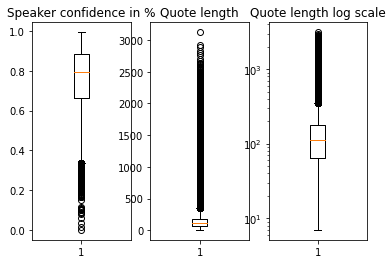

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.set_title('Speaker confidence in %')
ax1.boxplot(percentages)
ax2.set_title('Quote length')
ax2.boxplot(quote_lengths)
ax3.set_title('Quote length log scale')
ax3.boxplot(quote_lengths)
ax3.set_yscale('log')


We can see on these box plots several things: 

-Speaker confidence: almost all the data is between 40% and 100% confidence, with a high median of 80%, which is higher than we initially expected. Now, we think a vast majority of the time, when the Quotebank model was undecided on multiple speakers, it tends to assign "None", just like when it can't find the main speaker at all. And since no Qid is associated with "None", these quotes have been filtered out already in the previous steps. Still, there are a few outliers with very low confidence, and so we decided to remove any quote with less than 40% confidence.

-Quote length: As we can see, most of the quotes are below 500 characters long, with outliers going as far as 3000 characters. After a quick inspection, we determined that these outliers are indeed malformed quotes that "absorbed" part of the article with them, or stylistic choices wrongfully interpreted as a long quote (e.g. when the author of an article speak in the first person). Thus, we decided to remove any quotes with more than 500 characters. But on the other side of the spectrum, we can see we also have a non-negligible amount of very short quotes. We were worried that they were also malformed quotes, but upon closer inspection, they seem for the most part plausible, with the quote referencing a very specific part of a larger sentence. For instance, if Bob said "Donald is an old, fat, white man unfit for his job", the article may read "On Tuesday, Bob said harsh things about Donald, calling him an 'old, fat white man'.", so we end up with a very short quote from A. Still, we think it's hard to have a meaningful quote under 10 characters long, so we also exclude those.



In [ ]:
usableCount = 0
totalCount = 0

df = pd.read_csv(os.path.join(path_to_modified_folder, "single-qids-quotes-2020.json.bz2"), compression='bz2', chunksize=chunksize)

modified_filename = "filtered-percentage-and-quote-length-" + "single-qids-quotes-2020.json.bz2"
chunkCount = 1
header = True

try:
    os.remove(os.path.join(path_to_modified_folder, modified_filename))
except OSError:
    pass

for chunk in df:
  clear_output(wait=True)
  print(chunkCount)

  totalCount  = totalCount + chunk.shape[0]

  chunk = filterPercentageCSV(chunk)
  chunk = filterQuoteLength(chunk)

  usableCount = usableCount + chunk.shape[0]

  chunk.to_csv(os.path.join(path_to_modified_folder, modified_filename),
        header=header, mode='a', index = False)
  
  header = False
  chunkCount+=1
  
print("Total count: " + str(totalCount))
print("usable: " + str(usableCount))

9
Total count: 2511905
usable: 2457025


Next, we devise two sanity checks on our resulting dataset: The first one to make sure quotes effectively have a unique primary key in "quoteID", and the other to verify that the date of the quote is indeed consistent with the dataset it comes from.

In [ ]:
usableCount = 0
badIdCount = 0
totalCount = 0
#To check for Id uniqueness, we create a set of id hashes that we will keep growing as we move along chunks; that way we can quickly check if a new hash is in the set or not
precedentIds = set()

df = pd.read_csv(os.path.join(path_to_modified_folder, "filtered-percentage-and-quote-length-single-qids-quotes-2020.json.bz2"),parse_dates=["date"], compression='bz2', chunksize=chunksize)

modified_filename = "sanity-checked-filtered-percentage-and-quote-length-single-qids-quotes-2020.json.bz2"
chunkCount = 1
header = True

try:
    os.remove(os.path.join(path_to_modified_folder, modified_filename))
except OSError:
    pass

for chunk in df:
  clear_output(wait=True)
  print(chunkCount)

  totalCount  = totalCount + chunk.shape[0]
  #Here is where we check for id uniqueness, by creating a column of hash of the quoteID, checking uniqueness in the chunk and list, then adding it to said list
  badIdCount += chunk.shape[0]
  chunk["hashIds"] = chunk["quoteID"].apply(lambda x:hashlib.md5(x.encode()).digest())
  chunk = filterUniqueIds(chunk,precedentIds)
  precedentIds.update(chunk["hashIds"].tolist())
  chunk.drop(columns = ["hashIds"], inplace=True)
  badIdCount -= chunk.shape[0]

  chunk = filterIllegalDates(chunk,2020)

  usableCount = usableCount + chunk.shape[0]

  chunk.to_csv(os.path.join(path_to_modified_folder, modified_filename),
        header=header, mode='a', index = False)
  
  header = False
  chunkCount+=1
  
print("Total count: " + str(totalCount))
print("Bad ids:" + str(badIdCount))
print("usable: " + str(usableCount))

9
Total count: 2457025
Bad ids:0
usable: 2457025


Finally, we apply the filtering and sanity checks devised on the 2020 dataset on all the other years:

In [ ]:
year = 2015
usableCount = 0
totalCount = 0
badIdCount = 0
badYearCount = 0
#Iterates through the files from 2015 to 2019, as we already did 2020 above
for filename in filenames[:-1]:
  
  df = pd.read_json(os.path.join(path_to_folder, filename), lines=True, compression='bz2', chunksize=chunksize)

  modified_filename = "sanity-checked-filtered-percentage-and-quote-length-single-qids-" + filename
  precedentIds = set()
  chunkCount = 1
  header = True

  try:
      os.remove(os.path.join(path_to_modified_folder, modified_filename))
  except OSError:
      pass
  
  for chunk in df:
    clear_output(wait=True)
    print(filename + " " + str(chunkCount)) 

    totalCount  = totalCount + chunk.shape[0]

    chunk = filterSingleQid(chunk)
    chunk = filterPercentageJSON(chunk)
    chunk = filterQuoteLength(chunk)

    badIdCount += chunk.shape[0]
    chunk["hashIds"] = chunk["quoteID"].apply(lambda x:hashlib.md5(x.encode()).digest())
    chunk = filterUniqueIds(chunk,precedentIds)
    precedentIds.update(chunk["hashIds"].tolist())
    chunk.drop(columns = ["hashIds"], inplace=True)
    badIdCount -= chunk.shape[0]

    badYearCount += chunk.shape[0]
    chunk = filterIllegalDates(chunk,year)
    badYearCount -= chunk.shape[0]

    usableCount = usableCount + chunk.shape[0]

    chunk.to_csv(os.path.join(path_to_modified_folder, modified_filename),
          header=header, mode='a', index = False)
    
    header = False
    chunkCount+=1

  year+=1;

print("Total count: " + str(totalCount))
print("usable: " + str(usableCount))
print("Bad ids: " + str(badIdCount))
print("Bad years: " + str(badYearCount))


quotes-2019.json.bz2 73
Total count: 110339808
usable: 50083025
Bad ids: 0
Bad years: 0


In total, the dataset contains 115'584'257 entries, and after the filtering and cleaning we have 52'540'050 entries across the entire period of the dataset. We think that should be enough datapoints to get meaningful results in the project.

Now we want to make use of the additional metadata on speakers by adding their gender and occupations aside the quotes. To achieve it, we first extract these information and the corresponding qid, then merge with the quotation dataset. Here we perform the merge with the data of 2020, for the other years it goes the same way with just the corresponding year in file name.

In [ ]:
path_to_folder = '/content/drive/MyDrive/Quotebank-modified'
path_to_modified_folder = '/content/drive/MyDrive/Quotebank-modified'

filenames = ['sanity-checked-filtered-percentage-and-quote-length-single-qids-quotes-2020.json.bz2']
chunksize = 100000

In [ ]:
path_to_attributes = '/content/drive/MyDrive/speaker_attributes.parquet'

attr = pd.read_parquet(path_to_attributes)
attr

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055976,[Barker Howard],None,[Q30],[Q6581097],1397399351,None,None,[Q82955],None,None,Q106406560,Barker B. Howard,None,item,None
9055977,[Charles Macomber],None,[Q30],[Q6581097],1397399471,None,None,[Q82955],None,None,Q106406571,Charles H. Macomber,None,item,None
9055978,None,[+1848-04-01T00:00:00Z],None,[Q6581072],1397399751,None,None,None,None,None,Q106406588,Dina David,None,item,None
9055979,None,[+1899-03-18T00:00:00Z],None,[Q6581072],1397399799,None,None,None,None,None,Q106406593,Irma Dexinger,None,item,None


In [ ]:
#Keep only the attributes that we are interested in
attr_short = attr[['id', 'gender', 'occupation']]

#Drop rows with missing values
attr_no_null = attr_short.dropna()
print(attr_short.shape, attr_no_null.shape)

#Change the qids format form ['Q367796'] to Q367796 in order to merge with attributes
def filterSansCrochet(chunk):
  def sansCrochet(ids):
    ids = ids.replace("['","")
    ids = ids.replace("']","")
    return ids
  chunk['qids'] = chunk['qids'].apply(sansCrochet)
  return chunk



(9055981, 3) (4893542, 3)


In [ ]:
usableCount = 0
totalCount = 0
first_chunk = None
for filename in [filenames[-1]]:        
  df = pd.read_csv(os.path.join(path_to_folder, filename), compression='bz2', chunksize=chunksize)
  modified_filename = "gender-occupation" + filename
  chunkCount = 1
  header = True
  try:
      os.remove(os.path.join(path_to_modified_folder, modified_filename))
  except OSError:
      pass
  for chunk in df:
    clear_output(wait=True)
    print(chunkCount)
    totalCount  = totalCount + chunk.shape[0]
    
    chunk = filterSansCrochet(chunk)

    chunk = pd.merge(chunk, attr_no_null, left_on="qids", right_on = "id")

    chunk.to_csv(os.path.join(path_to_modified_folder, modified_filename),
          header=header, mode='a', index = False)
    header = False
    usableCount = usableCount + chunk.shape[0]
    chunkCount+=1
print("Total count: " + str(totalCount))
print("usable: " + str(usableCount))

24


We verify that gender and occupation columns are succesfully added to our dataset.

In [ ]:
joined = pd.read_csv(os.path.join(path_to_modified_folder, "gender-occupation" + filenames[0]), compression='bz2', chunksize=chunksize)

In [ ]:
chunk = next(joined)
chunk.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,id,gender,occupation
0,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,Q367796,2020-01-16 12:00:13,1,"[['Sue Myrick', '0.8867'], ['None', '0.0992'],...",['http://thehill.com/opinion/international/478...,E,Q367796,['Q6581072'],['Q82955']
1,2020-01-17-000357,[ The delay ] will have an impact [ on Slough ...,Dexter Smith,Q5268447,2020-01-17 13:03:00,1,"[['Dexter Smith', '0.924'], ['None', '0.076']]",['http://www.sloughexpress.co.uk/gallery/sloug...,E,Q5268447,['Q6581097'],['Q12299841']
2,2020-03-19-000276,[ These ] actions will allow households who ha...,Ben Carson,Q816459,2020-03-19 19:14:00,1,"[['Ben Carson', '0.9227'], ['None', '0.0773']]",['https://mortgageorb.com/hud-fha-suspend-fore...,E,Q816459,['Q6581097'],['Q212980' 'Q9385011' 'Q82955' 'Q482980' 'Q162...
3,2020-01-22-009723,be pivotal in addressing financial frustrations,Ben Carson,Q816459,2020-01-22 21:07:39,1,"[['Ben Carson', '0.7796'], ['None', '0.1278'],...",['https://www.wcbi.com/more-locales-weigh-repl...,E,Q816459,['Q6581097'],['Q212980' 'Q9385011' 'Q82955' 'Q482980' 'Q162...
4,2020-02-04-110477,We're talking about `Do we want to continue th...,Ben Carson,Q816459,2020-02-04 23:02:36,1,"[['Ben Carson', '0.8841'], ['None', '0.112'], ...",['https://www.complex.com/life/2020/02/ben-car...,E,Q816459,['Q6581097'],['Q212980' 'Q9385011' 'Q82955' 'Q482980' 'Q162...


We want to build a dictionary of news websites associated to their url count in the dataset to find the websites with the highest frequency, that we use for topic extraction. 
Indeed, urls can contain information about the topic to which the news article (and the quotation) belongs to. 

We focus on the 2020 dataset, as an example. The processing steps explained below can then be performed for the datasets of the other years. 

In [ ]:

d = defaultdict(lambda: 0) # initialize a dictionary whose default entries are 0

total_urls = 0 # we count the number of urls encountered as we traverse the dataset

df = pd.read_csv(os.path.join(path_to_modified_folder, "gender-occupationsanity-checked-filtered-percentage-and-quote-length-single-qids-quotes-2020.json.bz2"), compression='bz2', chunksize=chunksize)

chunkCount=0

for chunk in df:

  chunk["urls"] = chunk["urls"].apply(lambda x: ast.literal_eval(x)) # separate the url entries as list elements
  for urls in chunk["urls"]:
    total_urls += len(urls)
    for url in urls:
      domain = tldextract.extract(url)[1] # extract the domain name of the url
      d[domain]+=1
    

We can create a sorted dataframe to see the top 10 most recurring websites. Based on this, we can select 3 initial website candidates to extract our topics: nytimes, msn, and einnews.

However, even the most recurring sites represent only up to 1% of the total urls. This means that in our approach, there might be a need for several sites, to maximize our use of the data. 

In [ ]:
news_data = pd.DataFrame.from_dict(d,orient='index',columns=['website_counts']) # create dataframe from frequency dictionary

sorted_news_data = news_data.sort_values(by = "website_counts", axis = 0, ascending = False) # sort the entries by frequency in decreasing order

sorted_news_data["proportion"] = sorted_news_data["website_counts"]/total_urls # create a column to reflect their proportion

sorted_news_data.head(10)

,website_counts,proportion
einnews,141164,0.017514
msn,108528,0.013465
news965,54966,0.006820
breitbart,52947,0.006569
businessinsider,50731,0.006294
wokv,45059,0.005590
nbcsports,44499,0.005521
washingtontimes,39146,0.004857
indiatimes,36340,0.004509
foxnews,36317,0.004506


We create some functions to filter out rows of the dataset that contain urls of our chosen websites candidates: msn, einnews and nytimes.

In [ ]:
def filter_by_url(df,name): # select only the rows that have urls from msn news and return a new df that selects those urls 

  def filter_helper(urls): 
    return [url for url in urls if tldextract.extract(url)[1]==name ] # returns only the urls with the domain name "name"

  df["urls_" + name] = df["urls"].apply(lambda x: filter_helper(x)) # url lists matching the name

  df[name + "_counts"]= df["urls_"+name].apply(lambda x: len(x)) # number of urls matching the name

  return df[df[name + "_counts"]>0]

# take a chunk from the cleaned 2020 quotes dataset

df = pd.read_csv(os.path.join(path_to_modified_folder, "gender-occupationsanity-checked-filtered-percentage-and-quote-length-single-qids-quotes-2020.json.bz2"), compression='bz2', chunksize=chunksize)

chunk = next(df)

chunk["urls"] = chunk["urls"].apply(lambda x: ast.literal_eval(x))

# build a small dataset based on the chunk for each of our 3 website candidates

df_msn = filter_by_url(chunk, "msn")

df_einnews = filter_by_url(chunk, "einnews")

df_nytimes = filter_by_url(chunk, "nytimes")


Since there can be several urls per quote, we want to see if the amount of rows with several urls is significant enough (with respect to the volume of the 2020 dataset) to integrate url multiplicity into our topic analysis. Indeed, the ratio of mutliple urls (for msn, nytimes and einnews) is roughly around 20%-60%, which highlights their potential use to enrich the topic analysis (each url could provide an extra topic).

In [ ]:
# extract rows with more than 1 url for msn, einnews and nytimes

morethan1_msn = df_msn[df_msn['msn_counts']>1]

morethan1_einnews = df_einnews[df_einnews['einnews_counts']>1]

morethan1_nytimes = df_nytimes[df_nytimes['nytimes_counts']>1]


# investigate the proportion of multiple urls for the same news website

ratio_msn = len(morethan1_msn)/len(df_msn)  

ratio_einnews = len(morethan1_einnews)/len(df_einnews)  

ratio_ny = len(morethan1_nytimes)/len(df_nytimes)

print("ratio_ny =",ratio_ny)

print("ratio_msn =",ratio_msn)

print("ratio_einnews =", ratio_einnews)


ratio_ny = 0.31129196337741605
ratio_msn = 0.24485981308411214
ratio_einnews = 0.5880952380952381


Next, we look at the formatting of each of the three candidate urls to verify whether they contain topics or not. If they do, we want to see if the topics are consistently present in one part of the url, or if they occasionally appear in other parts of the url.


For msn urls: 
- There is a clear pattern in topic location within the url, msn urls are a suitable candidate for url topic extraction.

- The label "other" does not give further insight into the topic. It may have to be ignored.

- There is diversity in the topics across the different urls.

In [ ]:
print("msn quotes:")
for i in range(0,5):
  print("\nQuote "+str(i)+" :")
  for url in morethan1_msn.iloc[i]["urls_msn"]:
    print("url:",url)
    print("topic:",url.split("/")[5]) # split the url by "/" and extract the 5th element

msn quotes:

Quote 0 :
url: http://msn.com/en-au/news/world/murkowski-comes-out-against-impeachment-witnesses-putting-trump-on-path-to-acquittal/ar-BBZwzbZ?li=AAgfIYZ
topic: world
url: https://www.msn.com/en-us/news/politics/murkowski-comes-out-against-impeachment-witnesses-putting-trump-on-path-to-acquittal/ar-BBZwDWL?srcref=rss
topic: politics

Quote 1 :
url: http://msn.com/en-au/news/world/annabella-sciorra-testifies-in-weinstein-trial-he-raped-me/ar-BBZgRns?li=AAgfIYZ
topic: world
url: http://msn.com/en-au/news/world/annabella-sciorra-testifies-in-weinstein-trial-he-raped-me/ar-BBZgRns?li=BBU4PL8
topic: world

Quote 2 :
url: http://msn.com/en-xl/northamerica/northamerica-tech-science/why-spacex-wants-a-tiny-texas-neighborhood-so-badly/ar-BBZUoom?li=BBKxJ6T
topic: northamerica-tech-science
url: https://www.msn.com/en-us/news/other/why-spacex-wants-a-tiny-texas-neighborhood-so-badly/ar-BBZToTe?srcref=rss
topic: other

Quote 3 :
url: http://msn.com/en-xl/europe/europe-top-stories/in-r

The einnews urls do not contain topics. Thus, they are not suitable for topic extraction.

In [ ]:
# we look at the formatting of the einnews urls: there aren't any obvious topics to extract

print("\neinnews quotes:")
for i in range(0,5):
  print("\nQuote "+str(i)+" :")
  for url in morethan1_einnews.iloc[i]["urls_einnews"]:
    print("url:",url)


einnews quotes:

Quote 0 :
url: http://uspolitics.einnews.com/article/506997602/M43ygB-KE2bKKnCu
url: http://uspolitics.einnews.com/article/506997602/qVK5w_ukGQPn3DNB

Quote 1 :
url: http://brazilbusiness.einnews.com/article/507465438/dddtJiRfd3QVZN4u
url: http://brazilbusiness.einnews.com/article/507465438/p1tzpruMXLYpX7mG

Quote 2 :
url: http://uspolitics.einnews.com/article/506174830/2sumwpJY_BKc2RHm
url: http://uspolitics.einnews.com/article/506174830/B_8bZPDii-tt6guZ
url: http://uspolitics.einnews.com/article/506174830/Q-jBqQdUGDxFhwOA
url: http://uspolitics.einnews.com/article/506174830/XMZq8B8OVnG62eZG
url: http://uspolitics.einnews.com/article/506174830/kuAhyGkF6zuugRPQ
url: http://uspolitics.einnews.com/article/506174830/s-oILJd2fabnZs7H

Quote 3 :
url: http://uspolitics.einnews.com/article/509805430/1ORq2_mEJCERyWcg
url: http://uspolitics.einnews.com/article/509805430/O45F_q2dJ58Q-AKr

Quote 4 :
url: http://uspolitics.einnews.com/article/511143309/eskbd5-VAV1TkFFR
url: http:

For the nytimes urls: 
- There are some slight inconsistencies for topic positionning within the url. 
- For some urls (ex: quote 4), no topic can be extracted.
- Out of the examples below, topics for a given quote are often identical.

In [ ]:
print("\nnytimes quotes:")

for i in [1,4,6,9]:
  print("\nQuote "+str(i)+" :")

  for url in morethan1_nytimes.iloc[i]["urls_nytimes"]:
    l = url.split("/")
    print("url:",url)
    if len(l)>6:
      print("topic 1:",l[6]) # split the url by "/" and extract the 6th element
      if len(l)>7:
        print("topic 2:",l[7]) # extract the 6th element


nytimes quotes:

Quote 1 :
url: http://www.nytimes.com/2020/01/10/world/middleeast/trump-iran-embassies.html
topic 1: world
topic 2: middleeast
url: http://www.nytimes.com/2020/01/10/world/middleeast/trump-iran-embassy-attacks.html
topic 1: world
topic 2: middleeast
url: https://www.nytimes.com/2020/01/10/world/middleeast/trump-iran-embassies.html?emc=rss&partner=rss
topic 1: world
topic 2: middleeast

Quote 4 :
url: http://mobile.nytimes.com/2020/04/10/us/coronavirus-live-updates.html#commentsContainer
topic 1: us
topic 2: coronavirus-live-updates.html#commentsContainer
url: http://www.nytimes.com/2020/04/10/health/antibody-test-immunity.html
topic 1: health
topic 2: antibody-test-immunity.html

Quote 6 :
url: http://www.nytimes.com/2020/04/15/briefing/trump-who-south-korea-elections-wuhan.html
topic 1: briefing
topic 2: trump-who-south-korea-elections-wuhan.html
url: https://www.nytimes.com/2020/04/15/briefing/who-coronavirus-boxfish-.html
topic 1: briefing
topic 2: who-coronavirus-

We now create functions for topic extraction for msn news, as it is the most suitable out of all three candidates.

We create two extra columns for msn url quotes: 
- single_topic: where we extract a single topic by majority vote across all urls
- multiple_topics: where we include all distinct topics

For the project, as we might have to use and parse different urls to extract a significant amount of topics, one idea could be to create a dictionary mapping each url domain name to their own processing function.

For the following code cells, we choose to focus only on msn urls.

In [ ]:
# create functions for topic extraction for msn news

def extract_topic(urls): # return only one topic (most representative out of all urls)
  
  d = defaultdict(lambda: 0) 
  for url in urls:
    topic = url.split("/")[5]
    if topic!="other": # ignore "other"
      d[topic]+=1

  if d!={}:
    return max(d, key=d.get)
  else:
    return "none"

def extract_multiple_topics(urls):

  l =list({url.split("/")[5]:1 for url in urls}.keys()) # take the keys of a dictionary to avoid duplicates

  if "other" in l:
    l.remove("other")

  return l 

def add_topics(df,name):
  df["multiple_topics"] = df["urls_"+name].apply(lambda x: extract_multiple_topics(x))
  df["single_topic"] = df["urls_"+name].apply(lambda x: extract_topic(x))
  df["num_topics"] = df["multiple_topics"].apply(lambda x:len(x))

  return df


In [ ]:
# we append to the existing 2020 dataset some new columns with topic information

df = pd.read_csv(os.path.join(path_to_modified_folder, "gender-occupationsanity-checked-filtered-percentage-and-quote-length-single-qids-quotes-2020.json.bz2"), compression='bz2', chunksize=chunksize)

total_df = pd.DataFrame()

chunkCount = 1

name = "msn"

for chunk in df:

  print("Chunk number :", chunkCount)
  chunk["urls"] = chunk["urls"].apply(lambda x: ast.literal_eval(x))
  new_chunk = filter_by_url(chunk,name) # filter only msn urls

  print("Quotes in chunk :",len(new_chunk))
  new_chunk = add_topics(new_chunk, name) # topic extraction (single and multiple topics)
  total_df = total_df.append(new_chunk) # append to the result dataframe

  chunkCount += 1


Chunk number : 1
Quotes in chunk : 3210


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Chunk number : 2
Quotes in chunk : 3181
Chunk number : 3
Quotes in chunk : 3129
Chunk number : 4
Quotes in chunk : 3026
Chunk number : 5
Quotes in chunk : 2999
Chunk number : 6
Quotes in chunk : 3078
Chunk number : 7
Quotes in chunk : 3128
Chunk number : 8
Quotes in chunk : 3093
Chunk number : 9
Quotes in chunk : 2920
Chunk number : 10
Quotes in chunk : 3003
Chunk number : 11
Quotes in chunk : 3046
Chunk number : 12
Quotes in chunk : 3060
Chunk number : 13
Quotes in chunk : 3080
Chunk number : 14
Quotes in chunk : 2953
Chunk number : 15
Quotes in chunk : 3000
Chunk number : 16
Quotes in chunk : 3008
Chunk number : 17
Quotes in chunk : 3077
Chunk number : 18
Quotes in chunk : 3033
Chunk number : 19
Quotes in chunk : 3002
Chunk number : 20
Quotes in chunk : 3071
Chunk number : 21
Quotes in chunk : 3088
Chunk number : 22
Quotes in chunk : 3019
Chunk number : 23
Quotes in chunk : 3031
Chunk number : 24
Quotes in chunk : 1666


In [ ]:
total_df[["quotation","multiple_topics","single_topic","num_topics","msn_counts"]].iloc[:10]

,quotation,multiple_topics,single_topic,num_topics,msn_counts
12,It is your responsibility as secretary of HUD ...,[politics],politics,1,1
17,"In order for the healing to begin, the corrupt...","[latinamerica-top-stories, us]",latinamerica-top-stories,2,2
38,really run down and emotional.,[celebs],celebs,1,1
64,Las Vegas is now packing people into concrete ...,[us],us,1,1
88,Our nation-sized state knows first-hand the de...,[us],us,1,1
110,But we are not at this moment feeling that is ...,[us],us,1,1
122,"California stands with the people of Puerto Rico,",[us],us,1,1
135,back into Los Angeles all fixed,[us],us,1,1
168,will establish a unified homelessness data sys...,[us],us,1,1
257,"How the f ** k can teasing huge corporations, ...",[golden-globes],golden-globes,1,1


We want to see whether quotations with multiple topics represent a significant part of the dataset.

We see that they represent 7% of the dataset, which is small. However, this topic multiplicity may help to provide alternative topic labels if the single_topic label is not satisfactory. For instance, "politics" is more specific than "world", so the second topic may still be useful.

In [ ]:
total_df = total_df[total_df["single_topic"]!="none"] # drop the topics with none

print("proportion of quotes with multiple themes:",len(total_df[total_df["num_topics"]>1])/len(total_df))


proportion of quotes with multiple themes: 0.07436848058313435


Next, we want to see the topic distribution across our dataset: can quotations be grouped into big topic aggregates? What fraction of the topics is not useful for grouping quotations?

We see that more than half of the extracted topics have less than 50 quotations grouped under them. A potential strategy is to ignore them (as they won't be the main focus of the project). We could also complete interesting topics such as "nutrition" or "entertainment" with other news urls. We also notice that topics that have the same meaning such as "celebrity" or "celebs" are separated. By defining such "synonyms" we could aggregate the remaining minor topics to more significant groups.

We also witness big topic aggregates, on which we can perform our thematic analysis.

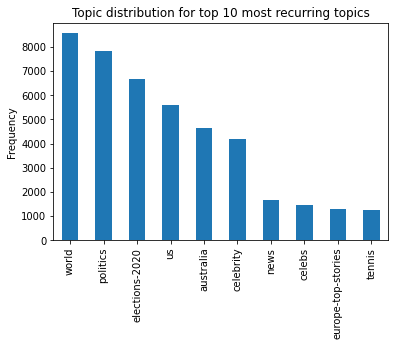

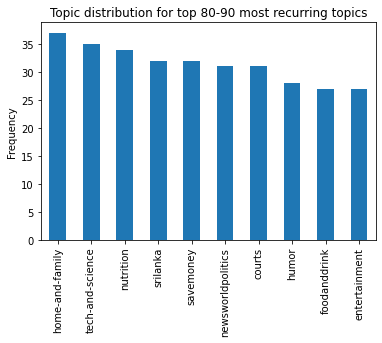

total number of topics: 201
under-represented topics: 130


In [ ]:
# we select only one topic (in the single_topics column) and plot the topics distribution

# plot the top 10 topics

plt.title("Topic distribution for top 10 most recurring topics")
total_df['single_topic'].value_counts().iloc[0:10].plot(kind='bar')
plt.ylabel("Frequency")
plt.show()

# plot the top 80 to 90 topics

plt.title("Topic distribution for top 80-90 most recurring topics")
total_df['single_topic'].value_counts().iloc[80:90].plot(kind='bar')
plt.ylabel("Frequency")
plt.show()

# compare number of under-represented topics to total topic number

total_topics = len(total_df['single_topic'].value_counts()) # total number of topics 

small_topics = len([v for v in total_df['single_topic'].value_counts().values if v<50]) # topics that group less than 50 quotations

print("total number of topics:", total_topics)
print("under-represented topics:", small_topics)

In [ ]:
# save df

name = "msn-articles-with-topics-gender-occupation-sanity-checked-filtered-percentage-and-quote-length-single-qids-quotes-2020.json.bz2"

total_df.to_csv(os.path.join(path_to_modified_folder, name), header=True)